# Getting started with High-Low Tide Composites (HLTC_25)

**What does this notebook do?** 

This notebook provides an introduction to the High and Low Tide Composites product (HLTC_25), which is composed of two surface reflectance composite mosaics of Landsat TM and ETM+ (Landsat 5 and Landsat 7 respectively) and OLI (Landsat 8) surface reflectance data (Li et al., 2012). These products have been produced using Digital Earth Australia (DEA). The two mosaics allow cloud free and noise reduced visualisation of the shallow water and inter-tidal coastal regions of Australia, as observed at high and low tide respectively ([Sagar et al. 2018](http://dx.doi.org/10.3390/rs10030480)).

**Requirements**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** August 2018

**Author:** Robbi Bishop-Taylor

## Import modules

In [1]:
import os
import sys
import datacube
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting

# Create datacube instance
dc = datacube.Datacube(app='HLTC')

## Overview of High-Low Tide Composite products

Inter-tidal zones are difficult regions to characterise due to the dynamic nature of the tide. They are highly changeable environments, subject to forcings from the land, sea and atmosphere and yet they form critical habitats for a wide range of organisms from birds to fish and sea grass. By harnessing the long archive of satellite imagery over Australia's coastal zones in the DEA and pairing the images with regional tidal modelling, the archive can be sorted by tide height rather than date, enabling the inter-tidal zone to be viewed at any stage of the tide regime.

The High Low Tide Composites (HLTC_25) product is composed of two mosaics, distinguished by tide height, representing a composite image of the synthetic geomedian surface reflectance from Landsats 5 TM, Landsat 7 ETM+ and Landsat 8 OLI NBAR data (Li et al., 2012; Roberts et al., 2017). [Oregon State University Tidal Prediction Software (OTPS)](http://volkov.oce.orst.edu/tides/otps.html) (Egbert and Erofeeva, 2002, 2010) was used to generate tide heights, relative to mean sea level, for the Australian continental coastline, split into 306 distinct tidal regions. These time and date stamped tidal values were then attributed to all coastal tile observations for their time of acquisition, creating a range of observed tide heights for the Australian coastline. The two mosaics in HLTC_25 are composited from the highest and lowest 20 % of observed tide in the ensemble. A geomedian composite for each Landsat band is calculated from the tiles in each ensemble subset to produce the respective High and Low Tide composites. Note that Landsat 7 ETM+ observations are excluded after May 2003 due to a large number of data artefacts. 

Four HLTC datasets are available through DEA: the High Tide 20 percentage composite, the Low Tide 20 percentage composite, the High Tide 20 percentage pixel / clear observations count, and the Low Tide 20 percentage pixel / clear observations count layer. All layers are in the Australian Albers `EPSG:3577` projection system, and have 25m pixel resolution:

In [2]:
# List metadata for ITEM products available in DEA
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
display(dc_products[dc_products.product_type == 'tidal_composite'][display_columns].set_index('name'))

,description,product_type,crs,resolution,spatial_dimensions
name,,,,,
high_tide_comp_20p,High Tide 20 percentage composites for entire ...,tidal_composite,EPSG:3577,"[-25, 25]","(y, x)"
high_tide_comp_count,High Tide 20 percentage pixel count,tidal_composite,EPSG:3577,"[-25, 25]","(y, x)"
low_tide_comp_20p,Low Tide 20 percentage composites for entire c...,tidal_composite,EPSG:3577,"[-25, 25]","(y, x)"
low_tide_comp_count,Low Tide 20 percentage pixel count,tidal_composite,EPSG:3577,"[-25, 25]","(y, x)"


## Import High and Low Tide composites
We can set up an extraction query for HLTC_25 using only spatial details (i.e. extent and projection): because HLTC_25 was computed by combining images from the entire Landsat time series into a single layer, it has no true temporal dimension (the layers do have a timestamp `2008-06-01`, but this is a meaningless placeholder value which is only required due to restrictions of the netCDF file format).

Each HLTC_25 composite contains six surface-reflectance spectral bands: blue, green, red, near-infrared, short-wave infrared 1 and short-wave infrared 2.

<div class="alert alert-info">
<b>Important note:</b> Please note that the surface reflectance values for each HLTC band are expressed as a floating point number between 0 and 1. This differs from surface reflectance values included with the DEA Landsat datasets, which are expressed as integers scaled between 0 and 10000.
</div>

In [3]:
# Set up analysis data query using a buffer around a lat-long point
lat, lon = -18.2066466248, 122.214634558
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - 8000, x + 8000),
         'y': (y - 8000, y + 8000),         
         'crs': 'EPSG:3577'}

# Import high and low tide composite layers
lowtidecomp_data = dc.load(product = 'low_tide_comp_20p', **query)
hightidecomp_data = dc.load(product = 'high_tide_comp_20p', **query)

# Squeeze out the unnecessary temporal dimensions:
lowtidecomp_data = lowtidecomp_data.squeeze(dim = 'time', drop = True)
hightidecomp_data = hightidecomp_data.squeeze(dim = 'time', drop = True)
print("Low Tide composite:\n\n", lowtidecomp_data, "\n")
print("High Tide composite:\n\n", hightidecomp_data)

Low Tide composite:

 <xarray.Dataset>
Dimensions:  (x: 641, y: 641)
Coordinates:
  * y        (y) float64 -1.977e+06 -1.977e+06 -1.977e+06 -1.977e+06 ...
  * x        (x) float64 -1.042e+06 -1.042e+06 -1.042e+06 -1.041e+06 ...
Data variables:
    blue     (y, x) float32 0.142985 0.14270617 0.14022838 0.14154135 ...
    green    (y, x) float32 0.13809542 0.13810375 0.13611284 0.13777812 ...
    red      (y, x) float32 0.04964104 0.049942903 0.047967885 0.04862893 ...
    nir      (y, x) float32 0.019549698 0.019038271 0.017294109 0.017598702 ...
    swir1    (y, x) float32 0.014030585 0.013525395 0.012839856 0.012547176 ...
    swir2    (y, x) float32 0.012055442 0.011902479 0.010675464 0.0107429875 ...
Attributes:
    crs:      EPSG:3577 

High Tide composite:

 <xarray.Dataset>
Dimensions:  (x: 641, y: 641)
Coordinates:
  * y        (y) float64 -1.977e+06 -1.977e+06 -1.977e+06 -1.977e+06 ...
  * x        (x) float64 -1.042e+06 -1.042e+06 -1.042e+06 -1.041e+06 ...
Data variables:
    

### Plot true-color High and Low Tide composites
We can now plot the HLTC_25 High and Low Tide composites, first in true color:

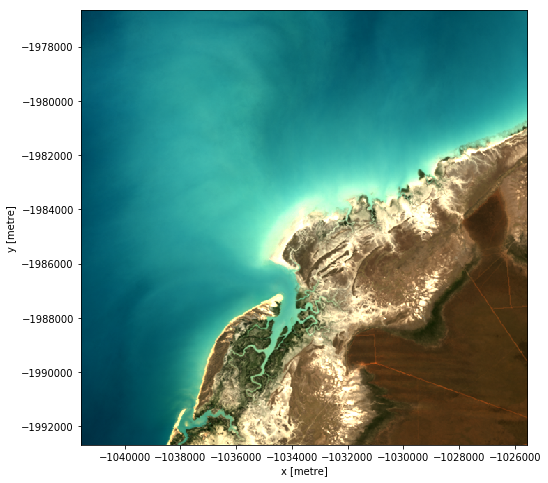

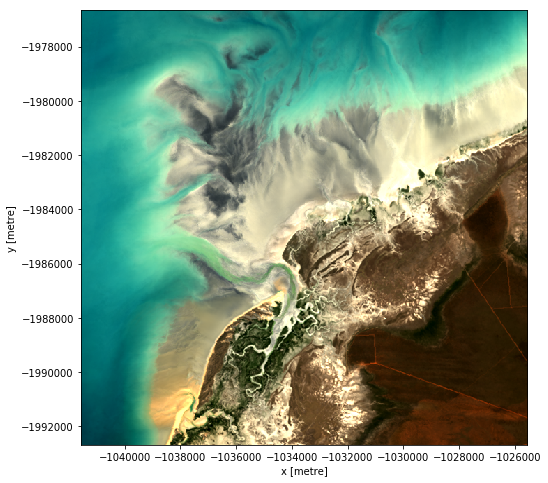

In [9]:
# Plot High and Low tide composites in true color by first converting to a three band array, 
# then using the `plot.imshow` method for plotting in colour
hightidecomp_data[['red', 'green', 'blue']].to_array().plot.imshow(robust=True, figsize=(8, 8))
lowtidecomp_data[['red', 'green', 'blue']].to_array().plot.imshow(robust=True, figsize=(8, 8))


...and in false color:

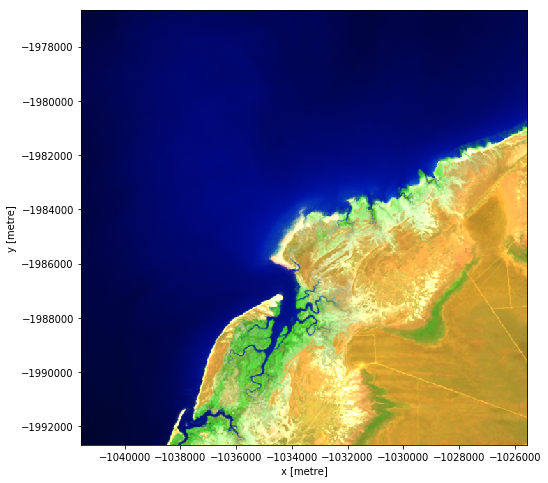

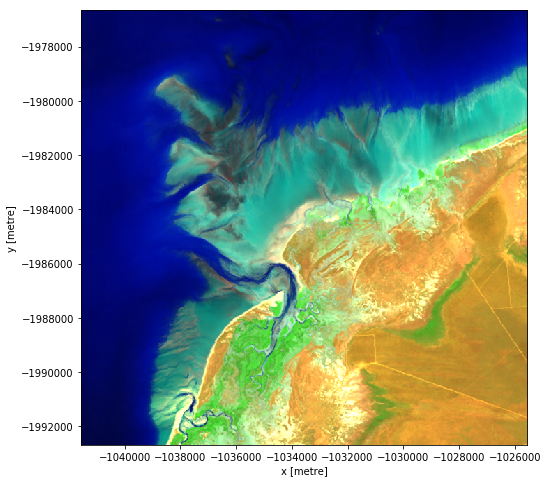

In [11]:
# Plot High and Low tide composites in false colour
hightidecomp_data[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, figsize=(8, 8))
lowtidecomp_data[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, figsize=(8, 8))

### How HLTC_25 composites correspond to Landsat observations and tidal heights
The following plots highlight the Landsat observations (black dots) that were used to generate the specific High and Low tide composites above, in relation to the full modelled tidal range (blue) and complete archive (white dots) for the particular location along Australia's coastline. For the below example, note how the observations used to create the High Tide composite come from the top 20% of the observed tidal range, and the Low Tide composite observations come from the bottom 20% of observations. The Low and High Tide composites from the example above also use different temporal selections of the Landsat time series: the time range used for composite generation was locally tailored for each composite to ensure dynamic coastal features were captured whilst still allowing a clean and cloud free composite to be generated. The maximum epoch for which the products are calculated is between 1995-2017, although this varies due to data resolution and observation quality. 

These plots are [available for all areas of Australia's coastline by clicking on an HLTC_25 polygon on National Map](https://nationalmap.gov.au/#share=s-42YrMXpOX9aW9Uhmxuc01c931kD), and provide valuable information for interpreting the HLTC_25 composite imagery.

High tide composite:

![High  tide composite](http://dea-public-data.s3-ap-southeast-2.amazonaws.com/LHTC_Tides/COMPOSITE_HIGH_209_122.2_-18.07_20000101_20170101_PER_20.jpg)

Low tide composite:

![Low tide composite](http://dea-public-data.s3-ap-southeast-2.amazonaws.com/LHTC_Tides/COMPOSITE_LOW_209_122.2_-18.07_20100101_20170101_PER_20.jpg)



## Import HLTC clear observations count layers
Prior to being combined into composite images, satellite observations were filtered to remove poor quality observations including cloud, cloud shadow and band saturation (of any band). To document this, the product also includes a count of clear observations per pixel for both mosaics:

In [12]:
# Import high and low tide composite layers
lowtidecount_data = dc.load(product = 'low_tide_comp_count', **query)
hightidecount_data = dc.load(product = 'high_tide_comp_count', **query)

# Squeeze out the unnecessary temporal dimensions:
lowtidecount_data = lowtidecount_data.squeeze(dim = 'time', drop = True)
hightidecount_data = hightidecount_data.squeeze(dim = 'time', drop = True)
print("Low Tide clear observations count:\n\n", lowtidecount_data, "\n")
print("High Tide clear observations count:\n\n", hightidecount_data)


Low Tide clear observations count:

 <xarray.Dataset>
Dimensions:             (x: 641, y: 641)
Coordinates:
  * y                   (y) float64 -1.977e+06 -1.977e+06 -1.977e+06 ...
  * x                   (x) float64 -1.042e+06 -1.042e+06 -1.042e+06 ...
Data variables:
    count_observations  (y, x) int16 23 23 24 24 24 24 24 24 24 24 24 24 24 ...
Attributes:
    crs:      EPSG:3577 

High Tide clear observations count:

 <xarray.Dataset>
Dimensions:             (x: 641, y: 641)
Coordinates:
  * y                   (y) float64 -1.977e+06 -1.977e+06 -1.977e+06 ...
  * x                   (x) float64 -1.042e+06 -1.042e+06 -1.042e+06 ...
Data variables:
    count_observations  (y, x) int16 61 60 59 60 60 60 60 59 59 60 60 62 62 ...
Attributes:
    crs:      EPSG:3577


### Plot HLTC clear observations count layers
Darker values indicate areas with fewer clear Landsat observations, which may have been caused by cloud, cloud shadow or band saturation (e.g. potentially caused by bright sand or sun glint):

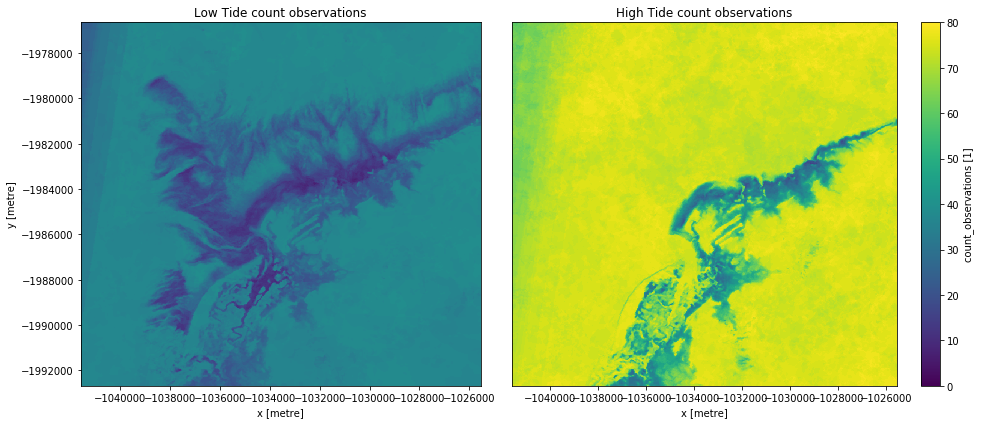

In [13]:
# Plot High and Low tide count observations side-by-side
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), gridspec_kw={'width_ratios':[0.83, 1]})
lowtidecount_data.count_observations.plot(vmin=0, vmax=80, ax=axes[0], add_colorbar=False)
axes[0].title.set_text('Low Tide count observations')
hightidecount_data.count_observations.plot(vmin=0, vmax=80, ax=axes[1])
axes[1].title.set_text('High Tide count observations')
axes[1].get_yaxis().set_visible(False)
fig.tight_layout()

## Computing remote sensing indices on HLTC_25 composites


Because the composites were produced using a geomedian approach that preserves the band relationships within the modelled spectra at each pixel, the surface reflectance values can be used for remote sensing applications (for example, image classification, remote sensing index calculation, habitat mapping) in exactly the same way as spectral bands from individual Landsat observations. For example, we can use the composites to compute simple remote sensing indices such as the Normalized Difference Water Index (NDWI). This index will have high values where a pixel is likely to be open water (e.g. NDWI > 0, or red colours below):

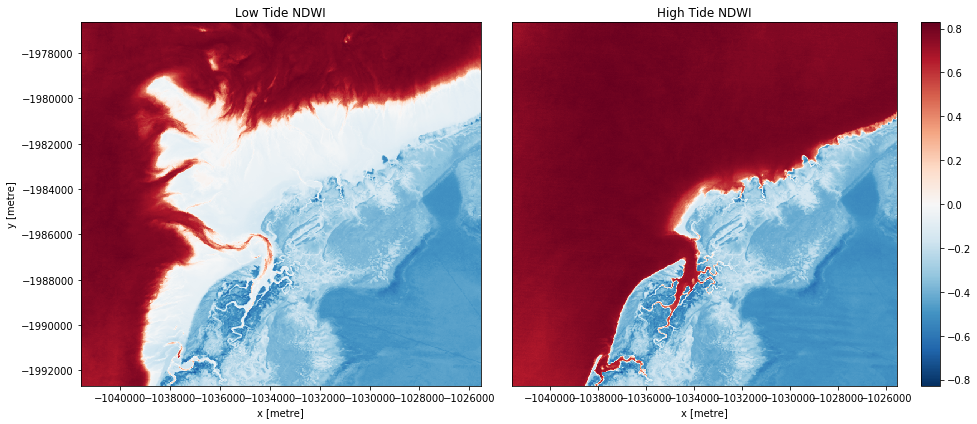

In [14]:
# Compute NDWI using the formula (green - nir) / (green + nir)
hightidecomp_ndwi = (hightidecomp_data.green - hightidecomp_data.nir) / \
                    (hightidecomp_data.green + hightidecomp_data.nir)
lowtidecomp_ndwi = (lowtidecomp_data.green - lowtidecomp_data.nir) / \
                   (lowtidecomp_data.green + lowtidecomp_data.nir)

# Plot High and Low tide NDWI side-by-side
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), gridspec_kw={'width_ratios':[0.83, 1]})
lowtidecomp_ndwi.plot(ax=axes[0], add_colorbar=False)
axes[0].title.set_text('Low Tide NDWI')
hightidecomp_ndwi.plot(ax=axes[1])
axes[1].title.set_text('High Tide NDWI')
axes[1].get_yaxis().set_visible(False)
fig.tight_layout()


A possible application of this may be to map the typical distribution of open water at low and high tide using a NDWI threshold:

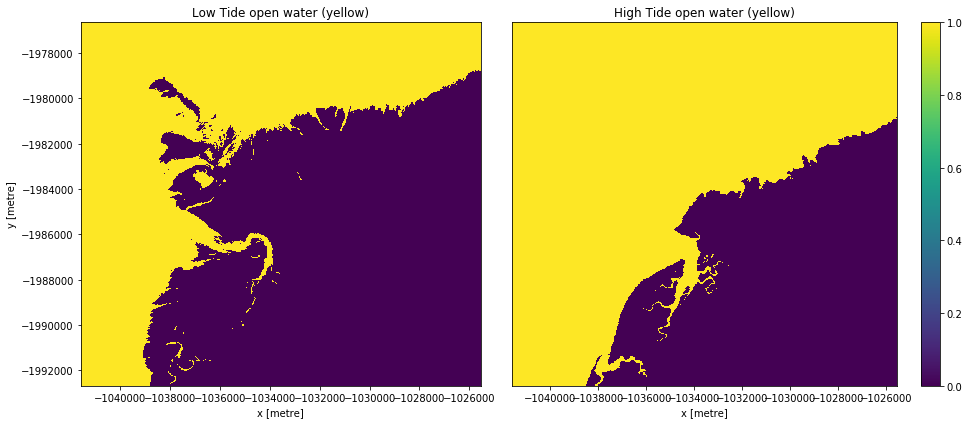

In [15]:
# Identify open water using an example threshold value of 0:
hightidecomp_water = hightidecomp_ndwi > 0
lowtidecomp_water = lowtidecomp_ndwi > 0

# Plot typical distribution of open water at high and low tide 
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), gridspec_kw={'width_ratios':[0.83, 1]})
lowtidecomp_water.plot(ax=axes[0], add_colorbar=False)
axes[0].title.set_text('Low Tide open water (yellow)')
hightidecomp_water.plot(ax=axes[1])
axes[1].title.set_text('High Tide open water (yellow)')
axes[1].get_yaxis().set_visible(False)
fig.tight_layout()